# 프로젝트 : 개선된 U-Net 모델 만들기  

목표 : UNet++ 모델을 만들고, 원래 UNet과 비교하기 

*프로젝트 설명: U-Net을 통한 시맨틱 세그멘테이션 결과가 충분히 만족스러우신가요? 어느정도 동작하는 것 같긴 하지만 좀더 개선할 여지도 보일 것입니다.*
*2018년에 U-Net++라는 논문이 나왔습니다. 이 논문은 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델입니다.*
*그래서 모델의 구조 자체는 아래 그림에서 보는 것처럼 별다른 설명이 없이도 직관적으로 이해가 가능한 수준입니다. 오늘 소개되었던 U-Net의 모델 코드를 조금만 수정 확장하면 충분히 구현할 수 있을 것입니다. 그래서 오늘의 과제는 바로 U-Net++ 모델을 스스로의 힘으로 직접 구현해 보고, U-Net을 활용했던 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었음을 확인해 보는 것입니다. 정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교해 볼 수 있을 것이고, 정량적으로는 동일 이미지에 대한 IoU값을 비교해 보면 될 것입니다.*  

*- (참고) U-Net++ 저자 블로그 https://sh-tsang.medium.com/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20*  

## Step 1. KITTI 데이터셋 수집과 구축
*Step설명: 다운받아 둔 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 내부적인 메모리 사용량이 U-Net보다 꽤 많아집니다. 8GB의 GPU 메모리를 가진 모델의 경우 학습데이터의 배치 사이즈를 16->4 로 줄여서 설정하시기를 권합니다.*

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import l2

print('슝=3')

슝=3


In [3]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

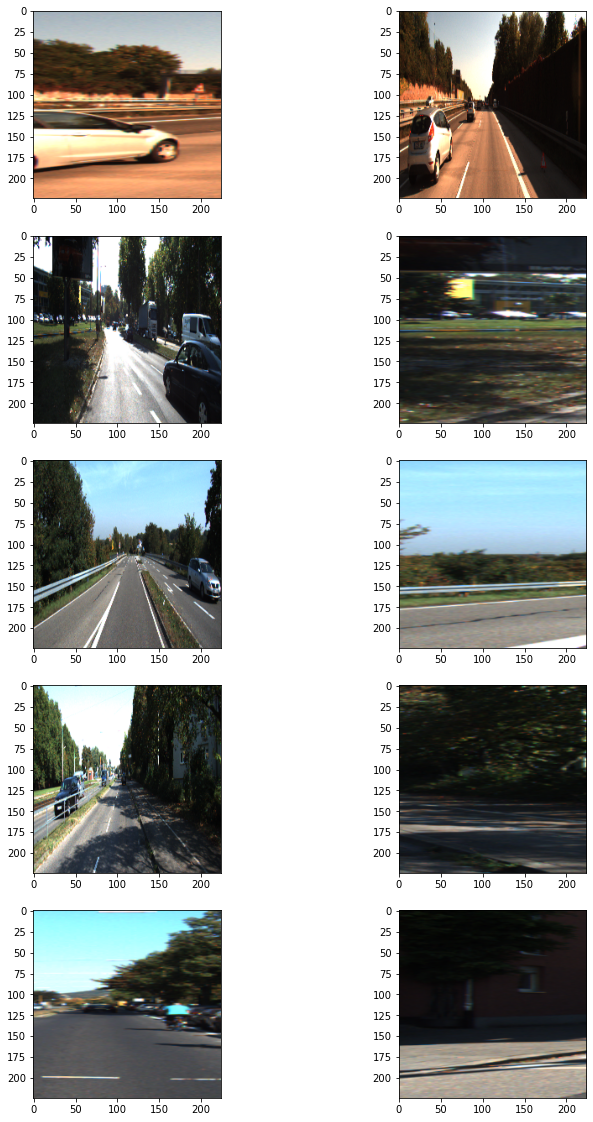

In [4]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i])
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])

plt.show()

In [5]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
              "image": _input,
              "mask": _output,
              }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

데이터 Augmentation, Train Set과 Test Set 생성

In [6]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Step 2. U-Net++ 모델의 구현
*Step설명 : U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다. 그 외 적절히 U-Net의 백본구조, 기타 파라미터 변경 등을 통해 추가적인 성능향상이 가능할수도 있습니다.*



<img src="./images/g8_3.png"></img>

UNet ++에는 원래 U-Net에 3 가지 추가 기능이 있다. 

1. redesigned skip pathways (녹색으로 표시)
2. dense skip connections (파란색으로 표시)
3. deep supervision (빨간색으로 표시)


구현 세부 정보 : 
- Dice coefficient 및 IoU (Intersection over Union)를 모니터링
- validation set에 early-stop 메커니즘을 사용
- learning rate이 3e-4 인 Adam 옵티 마이저를 사용
- UNet ++는 원래 U-Net 아키텍처에서 구성된다.
- 스킵 경로 (Xi, j)를 따라있는 모든 컨벌루션 레이어는 k = 32 x 2i 인 경우 3x3 (or 3×3×3 for 3D lung nodule segmentation) 크기의 k 커널을 사용
- deep supervision을 활성화하기 위해 각 대상 노드에 1x1 컨벌루션 레이어와 시그 모이 드 활성화 함수가 추가되었다. {x0, j | j ∈ {1, 2, 3, 4}}. 
- 결과적으로 UNet ++는 입력 이미지가 주어지면 4개의 세분화 맵을 생성하며 최종 세분화 맵을 생성하기 위해 추가 평균을 낸다.
- 자세한 내용은 github.com/Nested-UNet에서 확인할 수 있다.  

**참고)** Deep Supervision은 모든 세그먼테이션 브랜치(segmentation branches)들로 부터 출력된 출력값을 평균을 내서 예측률을 좀더 끌어올리고자 하는 것으로 보인다.  브랜치 중 한 개를 선택하는 빠른모드로서, 모델 pruning정도와 속도 영향을 준다. deep_supervision에 대해서는 실험하지 않았다. 

In [7]:
dropout_rate = 0.5
act = "relu"

def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv_'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(dropout_rate, name='dp_'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv_'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(dropout_rate, name='dp_'+stage+'_2')(x)

    return x

def build_model_unet_plusplus(img_rows, img_cols, color_type=1, num_class=1, deep_supervision=False):

    nb_filter = [64,128,256,512,1024]

    bn_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')
    
    # X^(0,0) 
    conv1_1 = standard_unit(img_input, stage='00', nb_filter=nb_filter[0])
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='pool_0')(conv1_1)
    
    # X^(1,0)
    conv2_1 = standard_unit(pool1, stage='10', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='pool_1')(conv2_1)
    
    # X^(0,1)
    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up_01', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge_01', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='01', nb_filter=nb_filter[0])

    # X^(2,0)
    conv3_1 = standard_unit(pool2, stage='20', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool_2')(conv3_1)

    # X^(1,1)
    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up_11', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge_11', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='11', nb_filter=nb_filter[1])

    # X^(0,2)
    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up_02', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge_02', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='02', nb_filter=nb_filter[0])

    # X^(3,0)
    conv4_1 = standard_unit(pool3, stage='30', nb_filter=nb_filter[3])
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool_3')(conv4_1)

    # X^(2,1)
    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up_21', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge_21', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='21', nb_filter=nb_filter[2])

    # X^(1,2)
    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up_12', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge_12', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='12', nb_filter=nb_filter[1])

    # X^(0,3)
    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up_03', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge_03', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='03', nb_filter=nb_filter[0])

    # X^(4,0)
    conv5_1 = standard_unit(pool4, stage='40', nb_filter=nb_filter[4])

    # X^(3,1)
    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up_31', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge_31', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='31', nb_filter=nb_filter[3])

    # X^(2,2)
    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up_22', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge_22', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='22', nb_filter=nb_filter[2])

    # X^(1,3)
    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up_13', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge_13', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='13', nb_filter=nb_filter[1])

    # X^(0,4)
    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up_04', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge_04', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='04', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(inputs=img_input, outputs=[nestnet_output_1,
                                               nestnet_output_2,
                                               nestnet_output_3,
                                               nestnet_output_4])
    else:
        model = Model(inputs=img_input, outputs=[nestnet_output_4])

    return model

In [14]:
model = build_model_unet_plusplus(224,224,3) # deep_supervision = False
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_00_1 (Conv2D)              (None, 224, 224, 64) 1792        main_input[0][0]                 
__________________________________________________________________________________________________
dp_00_1 (Dropout)               (None, 224, 224, 64) 0           conv_00_1[0][0]                  
__________________________________________________________________________________________________
conv_00_2 (Conv2D)              (None, 224, 224, 64) 36928       dp_00_1[0][0]                    
_______________________________________________________________________________________

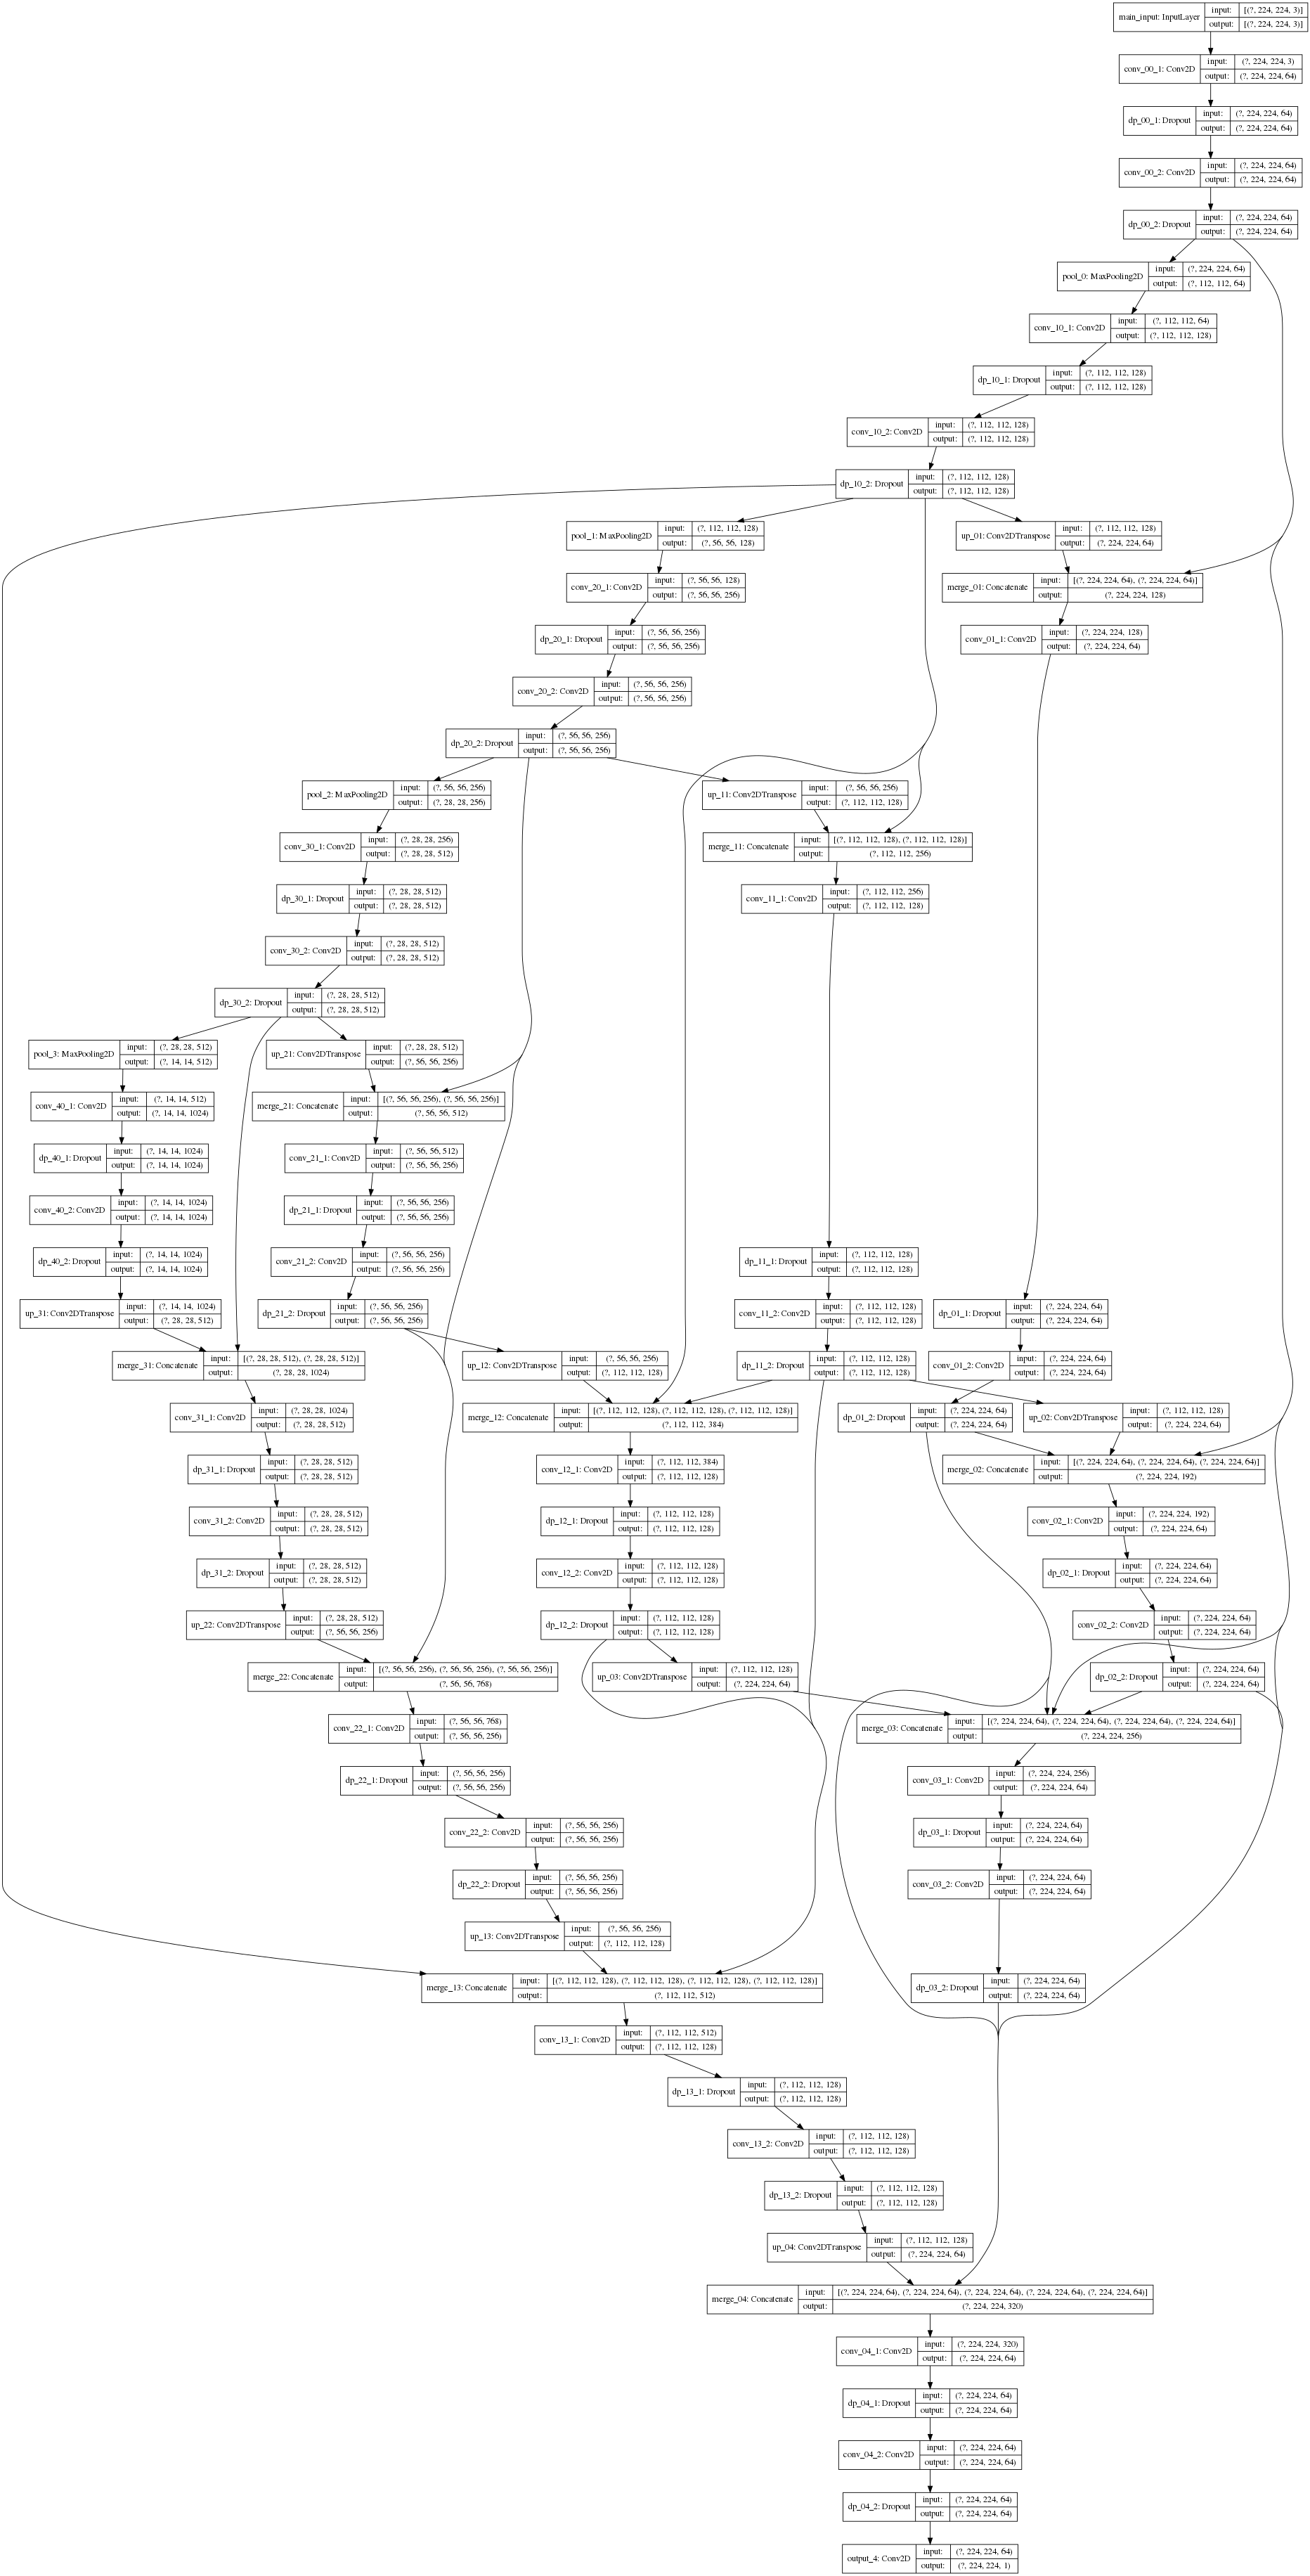

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

**epochs 100, deep_supervision=False**

In [23]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet_plusplus.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
43/43 [==============================] - 19s 433ms/step - loss: 2.3431 - val_loss: 2.0663
Epoch 2/100
43/43 [==============================] - 17s 389ms/step - loss: 1.8432 - val_loss: 1.5212
Epoch 3/100
43/43 [==============================] - 17s 395ms/step - loss: 1.4823 - val_loss: 1.4461
Epoch 4/100
43/43 [==============================] - 18s 423ms/step - loss: 1.4120 - val_loss: 1.3618
Epoch 5/100
43/43 [==============================] - 18s 420ms/step - loss: 1.3196 - val_loss: 1.2985
Epoch 6/100
43/43 [==============================] - 19s 445ms/step - loss: 1.2484 - val_loss: 1.2259
Epoch 7/100
43/43 [==============================] - 19s 450ms/step - loss: 1.1783 - val_loss: 1.1642
Epoch 8/100
43/43 [==============================] - 17s 400ms/step - loss: 1.1079 - val_loss: 1.0991
Epoch 9/100
43/43 [==============================] - 19s 439ms/step - loss: 1.0469 - val_loss: 1.0262
Epoch 10/100
43/43 [==============================] - 22s 523ms/step - loss: 0.987

**epochs 200, deep_supervision=False**

In [30]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=200,
 )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
43/43 [==============================] - 16s 382ms/step - loss: 0.1030 - val_loss: 0.1612
Epoch 2/200
43/43 [==============================] - 16s 383ms/step - loss: 0.0978 - val_loss: 0.1821
Epoch 3/200
43/43 [==============================] - 17s 385ms/step - loss: 0.0938 - val_loss: 0.1777
Epoch 4/200
43/43 [==============================] - 17s 390ms/step - loss: 0.0970 - val_loss: 0.1666
Epoch 5/200
43/43 [==============================] - 16s 384ms/step - loss: 0.0938 - val_loss: 0.1385
Epoch 6/200
43/43 [==============================] - 17s 392ms/step - loss: 0.0926 - val_loss: 0.1766
Epoch 7/200
43/43 [==============================] - 17s 399ms/step - loss: 0.0900 - val_loss: 0.1348
Epoch 8/200
43/43 [==============================] - 17s 386ms/step - loss: 0.0986 - val_loss: 0.1504
Epoch 9/200
43/43 [==============================] - 17s 384ms/step - loss: 0.0896 - val_loss: 0.1450
Epoch 

43/43 [==============================] - 17s 400ms/step - loss: 0.0640 - val_loss: 0.1079
Epoch 158/200
43/43 [==============================] - 18s 416ms/step - loss: 0.0571 - val_loss: 0.1131
Epoch 159/200
43/43 [==============================] - 17s 385ms/step - loss: 0.0552 - val_loss: 0.1237
Epoch 160/200
43/43 [==============================] - 16s 383ms/step - loss: 0.0532 - val_loss: 0.1257
Epoch 161/200
43/43 [==============================] - 16s 383ms/step - loss: 0.0622 - val_loss: 0.1310
Epoch 162/200
43/43 [==============================] - 16s 383ms/step - loss: 0.0570 - val_loss: 0.1442
Epoch 163/200
43/43 [==============================] - 17s 392ms/step - loss: 0.0524 - val_loss: 0.1627
Epoch 164/200
43/43 [==============================] - 17s 400ms/step - loss: 0.0536 - val_loss: 0.1333
Epoch 165/200
43/43 [==============================] - 16s 384ms/step - loss: 0.0530 - val_loss: 0.1097
Epoch 166/200
43/43 [==============================] - 16s 383ms/step - loss: 

In [31]:
model_path = dir_path + '/seg_model_unet_plusplus2.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

## Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
*Step설명 : 두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.*

### 3-1. 이미지 출력, IoU 계산 함수

In [100]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    output = Image.fromarray(output)
    
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [13]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

### 3-2. U-Net 

<img src="./images/g7_3.png"></img>  

In [33]:
unet_model_path = dir_path + '/seg_model_unet.h5'
unet_model = tf.keras.models.load_model(unet_model_path)

In [35]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 8    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     unet_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
)

<PIL.Image.Image image mode=L size=224x224 at 0x7F3D297B82D0>


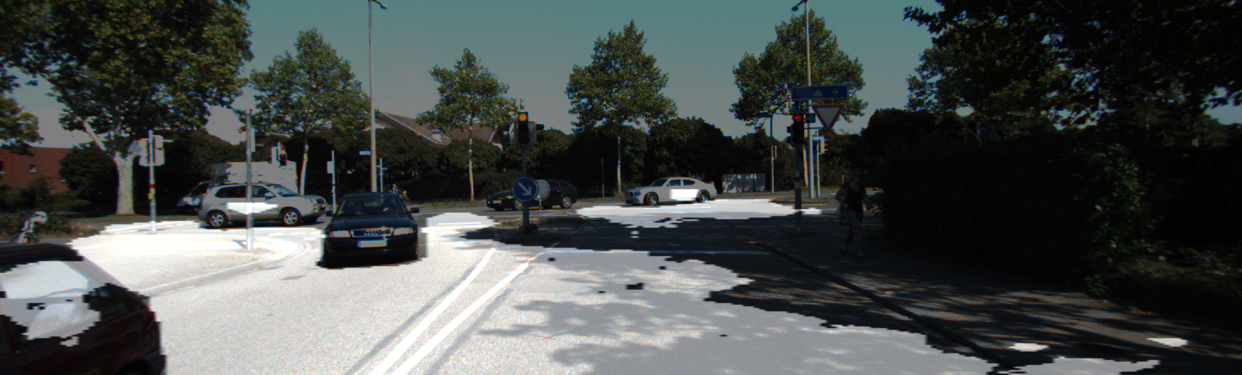

In [36]:
output

In [37]:
calculate_iou_score(target, prediction)

IoU : 0.680327


0.6803272592041651

### 3-3. U-NET++  (batch size 4,  epoch 100)

In [18]:
model_path = dir_path + '/seg_model_unet_plusplus.h5'
model = tf.keras.models.load_model(model_path)

In [22]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 8    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
)

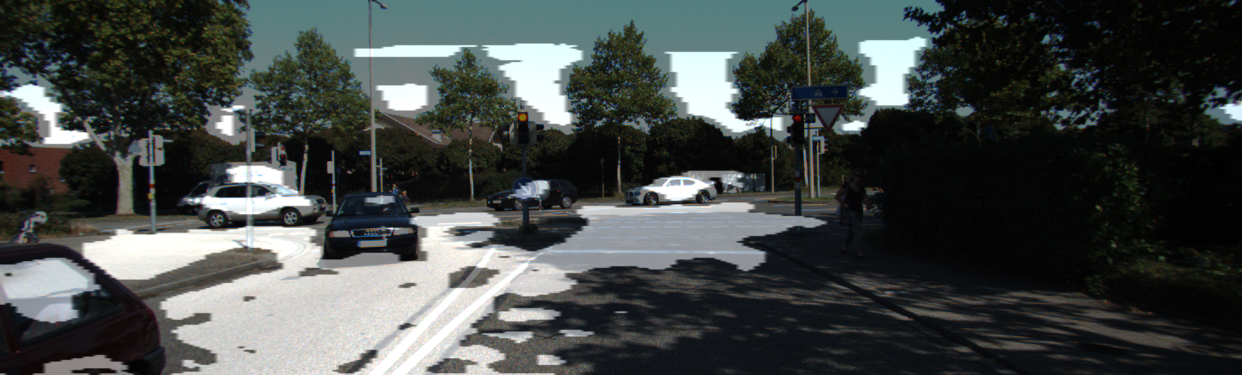

In [23]:
output

In [24]:
calculate_iou_score(target, prediction)

IoU : 0.371682


0.371682010617566

### 3-4. U-NET++  (batch size 4,  epoch 200)

In [86]:
model_path2 = dir_path + '/seg_model_unet_plusplus2.h5'
model2 = tf.keras.models.load_model(model_path2)

In [91]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 8    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model2, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
)

(224, 224)


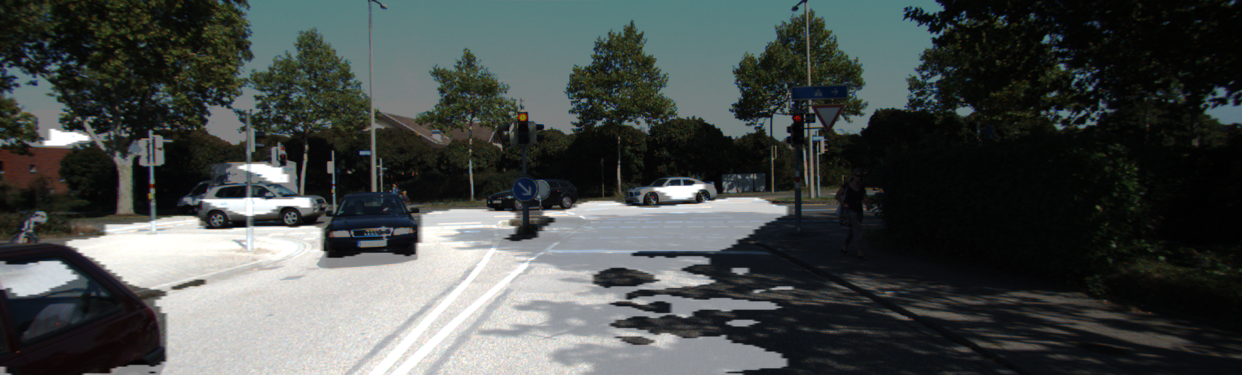

In [41]:
output

In [35]:
calculate_iou_score(target, prediction)

IoU : 0.634221


0.6342207643603631

## 결과
U-Net IoU : 0.680327   
UNet++ 100 epochs IoU: 0.371682   
UNet++ 200 epochs IoU: 0.634221   

UNet이 UNet++ 보다 성능이 좋았다.   
예상하는 결과는 아닌데...  

## 느낀점 
EXPLORATION의 세그멘테이션을 할 때 U-Net을 알게 되었다.   
그 때의 과제가 세그멘테이션을 좀 더 잘하기 위한 방법 찾기였다.   
내가 찾은 방법은 이미지의 깊이를 학습할 때 U-Net을 사용하는 방법이였다.    
네트워크의 모양이 특이해서 차후에라도 공부를 해야겠다고 생각했는데, Going Deeper에 나와서 좋았다.   
추가적으로 UNet은 Decode에서 Up-Sampling을 하게 되는데 그 방법에서 TensorFlow기준으로 UpSampling2D 와 Conv2DTranspose가 있다.   
UpSampling2D는 이미지를 간단히 확장하는 것으로 저렴하다는 장점이 있고, Conv2DTranspose는 모델을 학습하는 동안 Convolution 연산에서 해상도를 키우게 되는 것으로 패딩을 적당히 섞으면 H, W가 늘어나게 되는 것이 가능하다고 한다.   
두 모델에서 적당한 Up-Sampling을 학습해야 한다고 하는데 우리의 프로젝트에서 어떤 Up-Sampling이 적당한 것인지 잘 모르겠다.   
프로젝트에서 기본 UNet은 UpSampling2D를 사용했고, UNet++에서는 Conv2DTranspose를 사용했다.   
결과를 보았을 때 아무래도 이번 프로젝트의 데이터는 UpSampling2D를 사용했어야 하는가보다. 